# Photutils tutorial


## Morphological properties
Source: https://photutils.readthedocs.io/en/stable/morphology.html

## Elliptical Isophote Analysis
Source: https://photutils.readthedocs.io/en/stable/isophote.html

In [21]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_noise_image
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, data_properties
from astropy.io import fits
from astropy.visualization import simple_norm

In [22]:
#data = g(x, y) + noise
hdu=fits.open('/Users/lasilla/data/2020-02-10/reduced/NGC2997/NGC2997_V.fits')
data = hdu['PRIMARY'].data

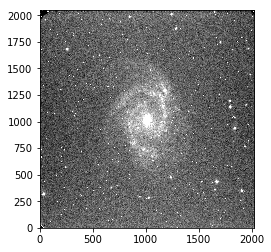

In [23]:
# how does it look?
plt.imshow(data, cmap='gray', origin='lower', vmin=16.4047, vmax=20.0625)

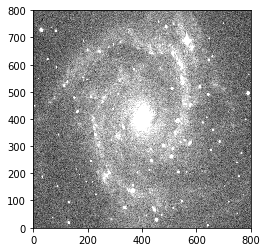

In [24]:
#cut
from astropy.nddata import Cutout2D
position = (1010, 1003)
size=(800,800)
cutout=Cutout2D (data,position,size)
plt.imshow(cutout.data,cmap='gray', origin='lower', vmin=16.4047, vmax=20.0625)

We first need to estimate an initial guess of the ellipse geometry and pass it to the fitters.

In [25]:
# image statistics 
mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
# subract background
data_sub = cutout.data - median
# first guess
cat = data_properties(data_sub)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = cat.to_table(columns=columns)
# initialize an ellipse with the properties that we guessed
geometry = EllipseGeometry(x0=tbl['xcentroid'][0].value,
                           y0=tbl['ycentroid'][0].value,
                           pa=tbl['orientation'][0].value,
                           sma=tbl['semimajor_axis_sigma'][0].value,
                           eps=tbl['semiminor_axis_sigma'][0].value/tbl['semimajor_axis_sigma'][0].value
                           )

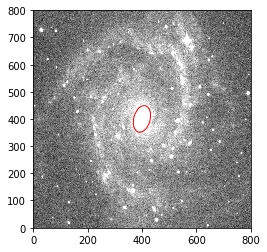

In [26]:
# how does it look?
geometry = EllipseGeometry (x0=400, y0=400, sma=50, eps=0.6,pa=75*np.pi/180)

plt.imshow(cutout.data, cmap='gray', origin='lower', vmin=16.4047, vmax=20.0625)
geometry.sma
aper = EllipticalAperture(positions=(geometry.x0, geometry.y0), 
                          a=geometry.sma,
                          b=geometry.sma*(geometry.eps),
                          theta=geometry.pa)
aper.plot(color='r')

Now we want to initiliaze an instance of the Ellipse class with the data and our initial guess and fit the data:

In [27]:
ellipse = Ellipse(data_sub, geometry)
isolist = ellipse.fit_image()

In [28]:
# save the output as a table
tab = isolist.to_table()
tab

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad_rerr,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,
float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64
0.0,55.208614850253426,0.0,0.0,0.0,0.0,0.0,None,1,0,0,0
0.5153723524097881,54.71488180199925,0.024648903903597138,0.5360798804351926,0.0178919356217904,90.7625893729,1.39526425073,0.5410849370184413,13,0,10,0
0.5669095876507669,54.641152332252744,0.02838447622089246,0.5292622739042605,0.01859800972315221,90.9923193434,1.46237792903,0.5553626957594183,13,0,10,0
0.6236005464158436,54.55638534394887,0.033051453720081135,0.5202182490927006,0.019577868004669544,91.2476736175,1.55555677531,0.5746168593214543,13,0,10,0
0.685960601057428,54.4603759765058,0.03883557140726382,0.5098929124861316,0.020831746740934413,91.5506477721,1.67725454656,0.598894080558655,13,0,10,0
0.7545566611631708,54.35241685564676,0.046025195020638655,0.49884425135028015,0.02232026815836242,91.9248056629,1.82116527498,0.6288399605678809,13,0,10,0
0.8300123272794878,54.23098725997773,0.054094580709036846,0.4879304229124213,0.023553966728763816,92.1806556381,1.94981300706,0.6474714621089529,13,0,10,0
0.9130135600074366,54.09685664073151,0.0630148934710465,0.47834714093986147,0.022384906448927485,92.3324852612,1.88186375362,0.5906595781788457,13,0,10,0


Text(0,0.5,'Ellipticity')

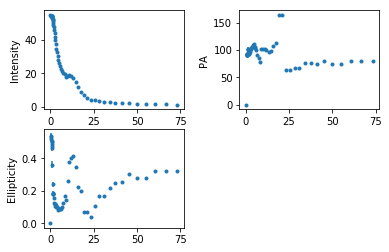

In [29]:
# have a look at some of the fitted parameters:
fig = plt.figure()
ax1 = fig.add_subplot(221)
fig.subplots_adjust(wspace=0.4)
ax1.errorbar(tab['sma'], tab['intens'],
             yerr=tab['intens_err'],
             fmt='.')
ax1.set_ylabel('Intensity')
ax2 = fig.add_subplot(222, sharex=ax1)
ax2.errorbar(tab['sma'], tab['pa'].value,
             yerr=tab['pa_err'].value,
             fmt='.')
ax2.set_ylabel('PA')
ax3 = fig.add_subplot(223, sharex=ax1)
ax3.errorbar(tab['sma'], tab['ellipticity'],
             yerr=tab['ellipticity_err'],
             fmt='.')
ax3.set_ylabel('Ellipticity')
# ax4 = fig.add_subplot(224, sharex=ax1)
# ax4.errorbar(tab['sma'], tab['x0'],
#              yerr=tab['x0_err'],
#              fmt='.')
# ax4.set_ylabel('x0')

We can also build a model image from the fit that we just calculated and deterime the residuals of the fit:

In [30]:
model_image = build_ellipse_model(cutout.data.shape, isolist)
residual = cutout.data - model_image

Text(0.5,1,'Residual')

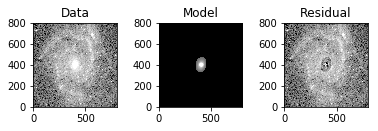

In [36]:
norm_model = simple_norm(model_image,stretch='asinh',percent=99.7)
norm_data = simple_norm(cutout.data,stretch='asinh',percent=98)
fig = plt.figure()
fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(131)
ax1.imshow(cutout.data, cmap='gray', origin='lower', norm=norm_data)
ax1.set_title('Data')
ax2 = fig.add_subplot(132)
ax2.imshow(model_image, cmap='gray', origin='lower', norm=norm_model)
ax2.set_title('Model')
ax3 = fig.add_subplot(133)
ax3.imshow(residual, cmap='gray', origin='lower', norm=norm_data)
ax3.set_title('Residual')

In [26]:
cutout.data

array([[17.904314, 17.424109, 18.218927, ..., 18.189936, 18.335066,
        18.620531],
       [17.850145, 17.619802, 17.049988, ..., 17.756903, 18.21741 ,
        18.012661],
       [17.20751 , 17.836355, 17.48718 , ..., 17.959875, 18.000162,
        17.559998],
       ...,
       [17.149042, 17.587244, 18.512695, ..., 17.99305 , 17.779224,
        17.799555],
       [17.98196 , 17.311922, 17.928762, ..., 17.742193, 17.14814 ,
        17.816133],
       [17.03715 , 17.69611 , 17.228767, ..., 17.67713 , 17.598856,
        17.872488]], dtype=float32)